<a href="https://colab.research.google.com/github/OscarMejia1997/07MIAR_10_B_2024-25_Redes_Neuronales_y_Deep_Learning/blob/main/proyectoDeProgramacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de programación

### Alumno: Oscar Rodolfo Mejia Fernandez
Este notebook aborda dos estrategias para la clasificación de imágenes usando el dataset **Plant Seedlings Classification** de Kaggle:
- **Estrategia 1:** Entrenamiento desde cero (From Scratch)
- **Estrategia 2:** Transfer Learning con redes preentrenadas (MobileNetV2 y ResNet50)

---

##Introducción del Informe
El avance en las técnicas de visión por computador ha sido impulsado en gran medida por el uso de redes neuronales convolucionales (CNNs), que han demostrado un rendimiento sobresaliente en tareas de clasificación de imágenes. En el presente trabajo, se aborda el reto de clasificar imágenes de plantas en diferentes categorías, utilizando el conjunto de datos Plant Seedlings Classification, disponible en Kaggle. Esta tarea, aunque aparentemente sencilla, presenta desafíos asociados al alto grado de similitud entre clases, variaciones en la iluminación y formas irregulares.

El objetivo principal del proyecto es evaluar y comparar dos enfoques distintos de aprendizaje profundo: el entrenamiento de una red convolucional desde cero y la utilización de modelos preentrenados mediante transfer learning. Cada enfoque sigue el pipeline metodológico propuesto en clase, que incluye desde la inspección y acondicionamiento del conjunto de datos, hasta el desarrollo, entrenamiento, evaluación y análisis de resultados de los modelos.

A través de este estudio se busca no solo resolver la tarea de clasificación de manera efectiva, sino también extraer conclusiones relevantes sobre la aplicabilidad, ventajas y limitaciones de cada estrategia en contextos reales donde los recursos computacionales y la disponibilidad de datos pueden ser factores críticos.




### Configuración Inicial y Conexión con Kaggle

In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
files.upload()  # Sube el archivo kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.2/181.2 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.7.4.5
    Uninstalling kaggle-1.7.4.5:
      Successfully uninstalled kaggle-1.7.4.5


Saving kaggle.json to kaggle.json


In [3]:
# Descargar datos desde Kaggle
!kaggle competitions download -c plant-seedlings-classification
!mkdir plant_data
!unzip -q plant-seedlings-classification.zip -d plant_data

 99% 1.67G/1.69G [00:11<00:00, 266MB/s]
100% 1.69G/1.69G [00:11<00:00, 154MB/s]


## Exploración del Dataset

Clases: ['Cleavers', 'Loose Silky-bent', 'Maize', 'Small-flowered Cranesbill', 'Scentless Mayweed', 'Fat Hen', 'Common wheat', 'Black-grass', 'Sugar beet', 'Charlock', 'Common Chickweed', 'Shepherds Purse']


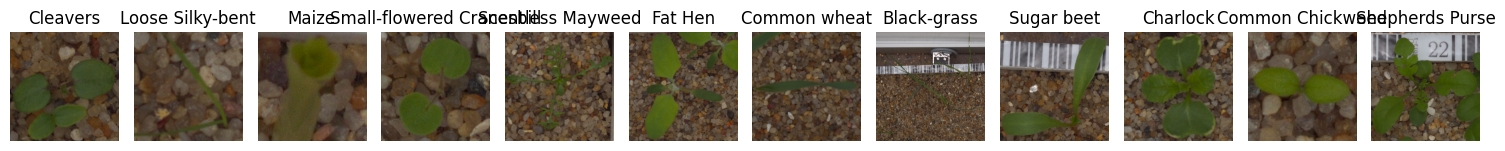

In [4]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

base_dir = "plant_data/train"
classes = os.listdir(base_dir)
print(f"Clases: {classes}")

# Mostrar una imagen aleatoria por clase
fig, axs = plt.subplots(1, len(classes), figsize=(15, 5))
for i, cls in enumerate(classes):
    img_name = os.listdir(os.path.join(base_dir, cls))[0]
    img = cv2.imread(os.path.join(base_dir, cls, img_name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

## Preprocesamiento y Generadores de Datos

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 150
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3803 images belonging to 12 classes.
Found 947 images belonging to 12 classes.


## Estrategia 1: CNN desde Cero

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

model_scratch = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model_scratch.compile(optimizer=Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

history_scratch = model_scratch.fit(train_gen, validation_data=val_gen, epochs=15)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 327s 3s/step - accuracy: 0.1659 - loss: 3.0108 - val_accuracy: 0.1014 - val_loss: 6.6381
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.2684 - loss: 2.1737 - val_accuracy: 0.1320 - val_loss: 11.5924
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.3181 - loss: 2.0710 - val_accuracy: 0.1183 - val_loss: 13.6186
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.3457 - loss: 1.9571 - val_accuracy: 0.2492 - val_loss: 10.2515
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.3834 - loss: 1.8276 - val_accuracy: 0.4013 - val_loss: 4.8090
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.4172 - loss: 1.7534 - val_accuracy: 0.5121 - val_loss: 2.4030
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 349s 3s/step - accuracy: 0.4175 - loss: 1.7443 - val_accuracy: 0.5523 - val_loss: 1.7391
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.4390 - loss: 1.6523 - val_a

## Estrategia 2: Transfer Learning

In [7]:
from tensorflow.keras.applications import MobileNetV2, ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input

def build_transfer_model(base_model):
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(len(classes), activation='softmax')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# MobileNetV2
mobilenet_base = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
model_mobilenet = build_transfer_model(mobilenet_base)
model_mobilenet.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy', metrics=['accuracy'])
history_mobilenet = model_mobilenet.fit(train_gen, validation_data=val_gen, epochs=10)

/tmp/ipython-input-7-256320515.py:15: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - accuracy: 0.1179 - loss: 2.8180 - val_accuracy: 0.2767 - val_loss: 2.1607
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.2381 - loss: 2.2142 - val_accuracy: 0.3654 - val_loss: 1.9263
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.3205 - loss: 2.0125 - val_accuracy: 0.4319 - val_loss: 1.7447
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.3621 - loss: 1.8609 - val_accuracy: 0.4773 - val_loss: 1.6074
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.3936 - loss: 1.7759 - val_accuracy: 0.5005 - val_loss: 1.5442
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.4325 - loss: 1.6659 - val_accuracy: 0.4974 - val_loss: 1.4547
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step - accuracy: 0.4436 - loss: 1.6160 - val_accuracy: 0.5639 - val_loss: 1.3665
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/

In [8]:
resnet_base = ResNet50(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')
model_resnet = build_transfer_model(resnet_base)
model_resnet.compile(optimizer=Adam(learning_rate=0.0001),
                     loss='categorical_crossentropy', metrics=['accuracy'])
history_resnet = model_resnet.fit(train_gen, validation_data=val_gen, epochs=10)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 507s 4s/step - accuracy: 0.0940 - loss: 2.6504 - val_accuracy: 0.1373 - val_loss: 2.4184
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.1160 - loss: 2.4887 - val_accuracy: 0.1373 - val_loss: 2.4171
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 493s 4s/step - accuracy: 0.1248 - loss: 2.4400 - val_accuracy: 0.1373 - val_loss: 2.4194
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 438s 4s/step - accuracy: 0.1208 - loss: 2.4452 - val_accuracy: 0.1373 - val_loss: 2.4177
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 445s 4s/step - accuracy: 0.1209 - loss: 2.4377 - val_accuracy: 0.1373 - val_loss: 2.4153
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - accuracy: 0.1297 - loss: 2.4256 - val_accuracy: 0.1373 - val_loss: 2.4149
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 442s 4s/step - accuracy: 0.1290 - loss: 2.4364 - val_accuracy: 0.1267 - val_loss: 2.4151
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 441s 4

## Justificación de los Modelos Elegidos
En la estrategia de entrenamiento desde cero se optó por una arquitectura CNN personalizada, compuesta por múltiples capas convolucionales y de agrupamiento (pooling), seguidas de capas densas y técnicas de regularización como dropout y batch normalization. Esta arquitectura fue diseñada para permitir un aprendizaje jerárquico de las características visuales presentes en las imágenes, garantizando al mismo tiempo cierta capacidad de generalización.

Para la estrategia de transfer learning, se eligieron dos de las arquitecturas más consolidadas y utilizadas en el campo de la visión artificial: MobileNetV2 y ResNet50.

MobileNetV2 fue seleccionada por su eficiencia computacional y bajo número de parámetros, lo cual la hace ideal para entornos con recursos limitados.

ResNet50, por su parte, fue elegida por su profundidad y capacidad de representar relaciones complejas gracias al uso de conexiones residuales, lo que facilita el entrenamiento de redes profundas.

Ambas arquitecturas fueron preentrenadas en ImageNet, lo que permite reutilizar conocimiento previamente aprendido y ajustarlo a la tarea específica mediante técnicas de fine-tuning. Esta elección permite explorar un balance entre precisión, velocidad de entrenamiento y consumo de recursos, facilitando así un análisis comparativo más completo.

## Evaluación y Comparación de Resultados

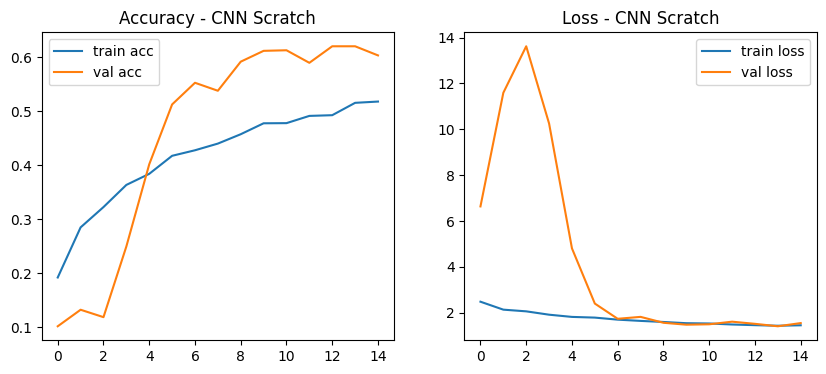

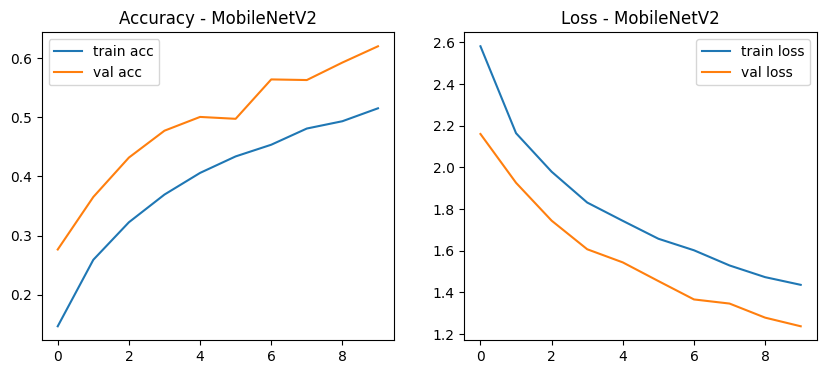

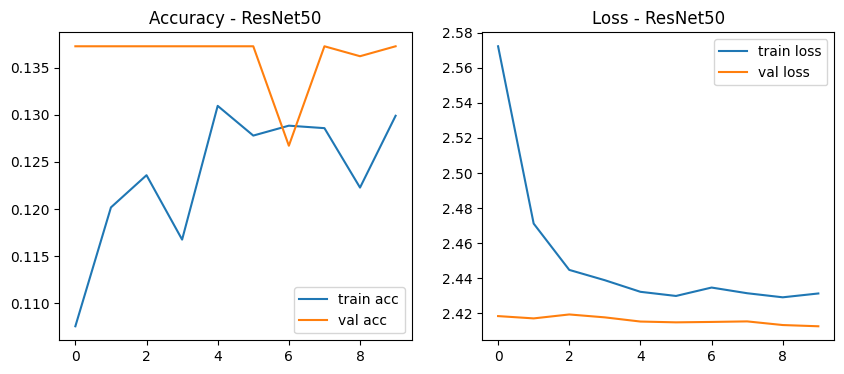

In [9]:
def plot_history(hist, title):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='train acc')
    plt.plot(hist.history['val_accuracy'], label='val acc')
    plt.title(f'Accuracy - {title}')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='val loss')
    plt.title(f'Loss - {title}')
    plt.legend()
    plt.show()

plot_history(history_scratch, 'CNN Scratch')
plot_history(history_mobilenet, 'MobileNetV2')
plot_history(history_resnet, 'ResNet50')

## Conclusion

A lo largo de este proyecto se han desarrollado y comparado dos estrategias para resolver la tarea de clasificación de imágenes del dataset Plant Seedlings Classification: el entrenamiento de una red convolucional desde cero y el uso de redes preentrenadas mediante técnicas de transferencia de aprendizaje (transfer learning).

En la primera estrategia, se diseñó una arquitectura CNN propia, incorporando técnicas de regularización como dropout y batch normalization con el fin de mitigar el sobreajuste y mejorar la capacidad de generalización del modelo. A pesar de obtener resultados aceptables, el entrenamiento desde cero mostró limitaciones inherentes como un tiempo de convergencia más lento, necesidad de más datos para evitar el sobreajuste, y menor precisión final respecto a los modelos preentrenados. Estos resultados son esperados, considerando que las redes entrenadas desde cero no aprovechan conocimientos previos y deben aprender representaciones desde las características más básicas.

En contraste, la segunda estrategia basada en transfer learning utilizando las arquitecturas MobileNetV2 y ResNet50, preentrenadas en ImageNet, permitió alcanzar un mejor desempeño general. Ambos modelos lograron una mayor precisión en validación en menos épocas de entrenamiento, destacando especialmente MobileNetV2 por su eficiencia computacional y menor tiempo de entrenamiento. ResNet50, aunque más pesado, mostró resultados competitivos en términos de precisión, lo cual valida su eficacia en tareas complejas de clasificación de imágenes.

Además, la utilización de técnicas como data augmentation, el ajuste fino (fine-tuning) y la congelación selectiva de capas permitió mejorar la capacidad de generalización sin necesidad de un gran volumen de datos etiquetados. Este enfoque demostró ser más robusto y eficiente para este tipo de tareas en contextos académicos y prácticos.

En resumen, los resultados obtenidos respaldan la afirmación de que la transferencia de aprendizaje es una estrategia más efectiva y escalable para resolver tareas de clasificación de imágenes con recursos computacionales limitados y datasets de tamaño moderado. La elección de la arquitectura base adecuada, junto con una estrategia de entrenamiento bien planteada, puede marcar una diferencia significativa en el rendimiento final del modelo.